# MinD Oscillations in E. coli

One spatial reaction-diffusion system that has been studied frequently in the literature both in a deterministic setting (Huang et. al, 2003) and using a stochastic description (Fange and Elf, 2006) is describing the periodic oscillations of Min proteins in the bacterium E. Coli. By oscillating from pole to pole, MinC suppresses the formation of a cell division site at the poles, indirectly positioning it in the middle of the cell.

References:
 - Kerwyn Casey Huang, Yigal Meir, and Ned S. Wingreen, Dynamic structures in Escherichia coli: Spontaneous formation of MinE rings and MinD polar zones,PNAS, 2003.
 - David Fange and Johan Elf, Noise-induced Min Phenotypes in E. Coli, PLOS Computational Biology, 2(6), 2006.

In [1]:
import matplotlib.pyplot as plt
import numpy
import os.path
import numpy
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import spatialpy

In [4]:
class Membrane(spatialpy.SubDomain):
    def inside(self,x,on_boundary):
        return on_boundary


class Cytosol(spatialpy.SubDomain):
    def inside(self,x,on_boundary):
        return not on_boundary


class MeshSize(spatialpy.DataFunction):
    def __init__(self,mesh):
        spatialpy.DataFunction.__init__(self, name="MeshSize")
        self.mesh = mesh
        self.h = mesh.get_mesh_size()
    
    def map(self, x):
        ret = self.h[self.mesh.closest_vertex(x)]
        return ret

In [11]:
class mincde(spatialpy.Model):
    """ Model of MinD oscillations in E. Coli, based on the model by Huang. et. al. in """

    def __init__(self,model_name="mincde"):
        spatialpy.Model.__init__(self,model_name)

        # Species
        MinD_m     = spatialpy.Species(name="MinD_m",diffusion_constant=1e-14,dimension=2)
        MinD_c_atp = spatialpy.Species(name="MinD_c_atp",diffusion_constant=2.5e-12,dimension=3)
        MinD_c_adp = spatialpy.Species(name="MinD_c_adp",diffusion_constant=2.5e-12,dimension=3)
        MinD_e     = spatialpy.Species(name="MinD_e",diffusion_constant=2.5e-12,dimension=3)
        MinDE      = spatialpy.Species(name="MinDE",diffusion_constant=1e-14,dimension=2)
        
        self.add_species([MinD_m,MinD_c_atp,MinD_c_adp,MinD_e,MinDE])
        
        # Make sure that we have the correct path to the mesh file even if we are not executing from the basedir.
        self.mesh = spatialpy.Mesh.read_xml_mesh("mesh/coli.xml")
        
        # List of Physical domain markers that match those in the  Gmsh .geo file.
        interior = 1
        boundary = 2
        # Mark the subdomain points        
        self.add_subdomain(Membrane(),boundary)
        self.add_subdomain(Cytosol(),interior)
        
        # Local mesh size to feed into the propensity functions
        self.add_data_function(MeshSize(self.mesh))
        
        # Parameters
        NA = spatialpy.Parameter(name="NA",expression=6.022e23)
        sigma_d  = spatialpy.Parameter(name="sigma_d",expression=2.5e-8)
        sigma_dD = spatialpy.Parameter(name="sigma_dD",expression=0.0016e-18)
        sigma_e  = spatialpy.Parameter(name="sigma_e",expression=0.093e-18)
        sigma_de = spatialpy.Parameter(name="sigma_de",expression=0.7)
        sigma_dt = spatialpy.Parameter(name="sigma_dt",expression=1.0)
        
        self.add_parameter([NA,sigma_d,sigma_dD,sigma_e,sigma_de,sigma_dt])

        
        # Reactions
        R1 = spatialpy.Reaction(name="R1",reactants={MinD_c_atp:1},products={MinD_m:1},propensity_function="MinD_c_atp*sigma_d/MeshSize", restrict_to=boundary)
        R2 = spatialpy.Reaction(name="R2",reactants={MinD_c_atp:1,MinD_m:1},products={MinD_m:2},rate=sigma_dD)
        R3 = spatialpy.Reaction(name="R3",reactants={MinD_m:1,MinD_e:1},products={MinDE:1},rate=sigma_e)
        R4 = spatialpy.Reaction(name="R4",reactants={MinDE:1},products={MinD_c_adp:1,MinD_e:1},rate=sigma_de)
        R5 = spatialpy.Reaction(name="R5",reactants={MinD_c_adp:1},products={MinD_c_atp:1},rate=sigma_dt)
        R6 = spatialpy.Reaction(name="R6",reactants={MinDE:1,MinD_c_atp:1},products={MinD_m:1,MinDE:1},rate=sigma_dD)
        
        self.add_reaction([R1,R2,R3,R4,R5,R6])
        
        # Restrict to boundary
        self.restrict(MinD_m,boundary)
        self.restrict(MinDE,boundary)
        
        # Distribute molecules over the mesh according to their initial values
        #self.set_initial_condition_scatter({MinD_c_adp:4500})
        #self.set_initial_condition_scatter({MinD_e:1575})
        self.add_initial_condition(spatialpy.ScatterInitialCondition(
                                        MinD_c_adp,4500))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(
                                        MinD_e,1575))

        self.timespan(range(500))

In [12]:
model = mincde(model_name="mincde")

In [13]:
%time result = model.run(report_level=1)

Compiling Solver.  Build dir: /tmp/tmp3ns7hwg_
Elapsed seconds: 1.90

CPU times: user 10.3 s, sys: 48.1 ms, total: 10.3 s
Wall time: 14.2 s


In [28]:
from spatialpy.nsmsolver import NSMSolver
sol = NSMSolver(model, report_level=2)
%time result = sol.run()

Compiling Solver.  Build dir: /tmp/tmp9l4vzfwp
Creating propensity file /tmp/tmp9l4vzfwp/mincde_generated_model.c
self.listOfInitialConditions(MinD_c_adp,4500).apply()
self.listOfInitialConditions(MinD_e,1575).apply()
cmd: cd /tmp/tmp9l4vzfwp ; make -f /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile.nsm ROOT=/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/tmp9l4vzfwp/mincde_generated_model.c BUILD=/tmp/tmp9l4vzfwp

gcc -c -o linked_list.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o particle.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall 
gcc -c -o simulate.o /home/brian/Desktop/research/SpatialPy/s

In [23]:
result.read_step(0)

(array([[  0.00000000e+00,  -2.49999999e-07,   0.00000000e+00],
        [  2.49999999e-07,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   2.25000008e-06,   0.00000000e+00],
        ..., 
        [  1.97016689e-07,   8.37633365e-07,   4.60256508e-08],
        [  4.85833560e-08,   9.95835649e-07,   1.82054222e-07],
        [  6.94389684e-08,   1.64003507e-06,   1.77651373e-07]], dtype=float32),
 {'C[MinDE]': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'C[MinD_c_adp]': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'C[MinD_c_atp]': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'C[MinD_e]': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'C[MinD_m]': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'id': array([   0,    1,    2, ..., 1025, 1026, 1027], dtype=int32),
  'mass': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'rho': array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
  'type': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
  'v': array([[ 0.,  0.,  0.],
         [ 0.,

In [21]:
model.mesh.vertices.shape

(1028, 3)

Text(0,0.5,'Copy number of membrane bound MinD in half of the cell')

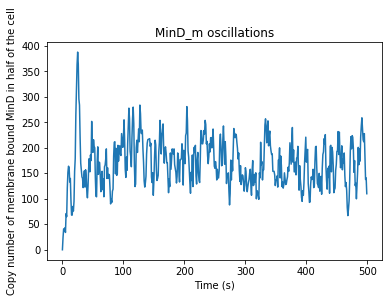

In [48]:
mindm = result.get_species("MinD_m")

y_vals = model.mesh.coordinates()[:, 1]
idx = y_vals < 1e-6
mindmsum = numpy.sum(mindm[:,idx],axis=1)
plt.plot(model.tspan, mindmsum)
plt.title('MinD_m oscillations')
plt.xlabel('Time (s)')
plt.ylabel('Copy number of membrane bound MinD in half of the cell')

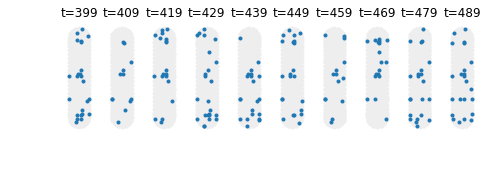

In [47]:
mx = numpy.max(mindmsum)
tmax = [i for i, j in enumerate(mindmsum) if j == mx][0]
tlist = range(model.tspan[-1]-100,model.tspan[-1],10)
plt.figure(figsize=(len(tlist)*0.75,2))
for num, tnow in enumerate(tlist):
    minD1 = result.get_species("MinD_m", tnow)
    xlist = []
    ylist = []
    zlist = []
    cutoff = 5
    for vndx, minD_val in enumerate(minD1):
        if minD_val > cutoff:
            c = model.mesh.coordinates()[vndx,:]
            #print vndx, minD_val, c
            xlist.append(c[0])
            ylist.append(c[1])
            zlist.append(c[2])

    plt.subplot(1,len(tlist),num+1)
    plt.plot(model.mesh.coordinates()[:,0], model.mesh.coordinates()[:,1], '.', color='#eeeeee')
    plt.plot(xlist,ylist,'.')
    plt.title('t={0}'.format(tnow))
    plt.xlim(-3e-7, 3e-7)
    plt.ylim(-5e-7, 25e-6)
    plt.axis('equal')
    plt.axis('off')


In [33]:
minD1.shape

(1, 1028)